# Interest Rate Curves 

A $n\times 1$ swap is a swap that changes $n$ 

$$
    V_{fixed} = V_{floating}
$$

Where
$$
    V_{fixed} = \sum_{k=1}^{n}r_n\tau_n
$$

In [891]:
%matplotlib notebook

In [861]:
holidays = []
with open("curves/holidays.txt", "r") as f:
    dates = f.read().split("\n")
    for date in dates:
        holidays.append(datetime.strptime(date, "%m/%d/%y"))

In [875]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
from scipy.interpolate import interp1d

class RateCurves(object):
    def __init__(self, val_date, market_coupons,
                 number_flows, coupon_length, holidays=None):
        """
        Class to construct an interest rate curve lattice using market swap quotations
        :parameters:
        :val_date: The reference date to construct the curve
        :holidays: A numpy array list of datetime objects used to indicate when a weekday is not a
                   workday
        :pillars: 
        """
        self.val_date = val_date
        self.number_flows = number_flows
        self.coupon_length = coupon_length
        self.holidays = holidays
        self.pillars = self.compute_pillars()
        self.market_coupons = market_coupons
        self.discount_rates = np.zeros(len(pillars))
        self.days_to_pillar = np.array([(pillar - self.val_date).days
                                        for pillar in  self.pillars])
        self.market_flows = dict()
        self.fitted_curve = False
        self.rate_curve = None
        
    def compute_pillars(self):
        """
        Compute the maturity date for each of the market nx1 swaps in 
        the market
        """
        horizons = self.number_flows * self.coupon_length
        pillars = []
        for horizon in horizons:
            end_date = self.forward_busdays(int(horizon))
            pillars.append(end_date)
        
        return pillars
    
    def forward_busdays(self, days):
        """
        Return the date corresponding to the start date
        plus a given number of days. If the end date is either a weekend
        or a holiday, move forward one day until a workday is found
        """
        end_date = self.val_date + timedelta(days)
        weekday = end_date.weekday()

        if ((self.holidays is not None) and (end_date in self.holidays)) \
           or (weekday in [5,6]):
            return forward_busdays(end_date, 1, self.holidays)
        else:
            return end_date
    
    def length_flows(self, nflows):
        """
        Retrieve the start, end and number of days of "n" flows.
        """
        start_periods = np.array([forward_busdays(self.val_date,
                                  self.coupon_length * period, holidays)
                                  for period in range(nflows)])
        
        end_periods = np.array([forward_busdays(self.val_date,
                                self.coupon_length * period, holidays)
                                for period in range(1, nflows + 1)])

        period_days = np.array([(end - start).days for
                                start, end in zip(start_periods, end_periods)])

        return period_days
    
    # TODO: Add market conventions to compute the coupons 
    #       and the discount factor
    def estimate_bond_price(self, nth_rate, nflows):
        """
        Price a bond paying n fixed coupons + principal where
        the nth rate is unkown. The price of this bond should be 1,
        and the approximation to 1 is given by the input rate.
        This function is necessary to find the nth rate such that
        makes the value of bond 1.
        """
        rates_nx1 = self.discount_rates.copy()
        
        # Length of each coupon to pay
        coupons_len = self.length_flows(nflows)
        
        # Find the index to replace the rate
        rate_index = np.where(self.number_flows == nflows)[0]
        if len(rate_index) == 0:
            raise ValueError("The structure lattice has no {}x1 instrument".format(nflows))
        
        swap_coupon = self.market_coupons[rate_index]
        # Modifying the rates
        rates_nx1[rate_index] = nth_rate
        lattice = interp1d(self.days_to_pillar, rates_nx1)
        discount_rates = lattice(coupons_len.cumsum())
        
        pv_coupons = coupons_len / 360  * swap_coupon / (1 + discount_rates * coupons_len.cumsum() / 360)
        pv_principal = 1 / (1 + discount_rates[-1] * coupons_len.cumsum()[-1] / 360)
        
        return np.sum(pv_coupons) + pv_principal
    
    def estimate_pillar_discount_rate(self, nflows, i0=0):
        """
        Estimate the nth rate discount for a nx1 market swap,
        assuming all other discount factors are known.
        """
        rate_err = lambda rate: 1e6 * (self.estimate_bond_price(rate, nflows) - 1) ** 2
        rate_result = minimize(rate_err, i0, tol=1e-20)
        return rate_result
    
    def fit_curve(self, i0=0):
        """
        """
        for ix, nflow in enumerate(self.number_flows):
            irate = self.estimate_pillar_discount_rate(nflow, i0)
            self.discount_rates[ix] = irate.x[0]
        self.fitted_curve = True
        self.rate_curve = interp1d(self.days_to_pillar, self.discount_rates)

### TIIE28

In [876]:
# The constant coupon rates for nx1 swaps trading liquid in the market
mid_mkt = np.array([0.0409 ,  0.04315,  0.0446 ,  0.046  ,  0.04765,  0.05035,
                    0.05245,  0.0543 ,  0.05605,  0.05905,  0.06215,  0.06401,
                    0.0668 ,  0.06911,  0.07142])

# 'n' flows of of a variable rate v.s. one fixed rate
nx1_instruments = np.array([1, 3, 6, 9, 13, 26, 39, 52, 65, 91, 130, 156, 195, 260, 390])

val_date = datetime(2016, 6, 27)
tiie28 = RateCurves(val_date, mid_mkt, nx1_instruments, 28, holidays)

In [877]:
print(tiie28.discount_rates)
print(tiie28.fitted_curve)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
False


In [878]:
tiie28.fit_curve()

In [879]:
print(tiie28.discount_rates)
print(tiie28.fitted_curve)

[ 0.04089999  0.04330003  0.04500234  0.04668823  0.0487722   0.05300998
  0.05695582  0.06097714  0.06527678  0.07444921  0.08906129  0.10105983
  0.12491065  0.16995148  0.31693922]
True


In [882]:
tiie28.days_to_pillar

array([   28,    84,   169,   252,   364,   728,  1092,  1456,  1820,
        2548,  3640,  4368,  5460,  7280, 10920])

<IPython.core.display.Javascript object>


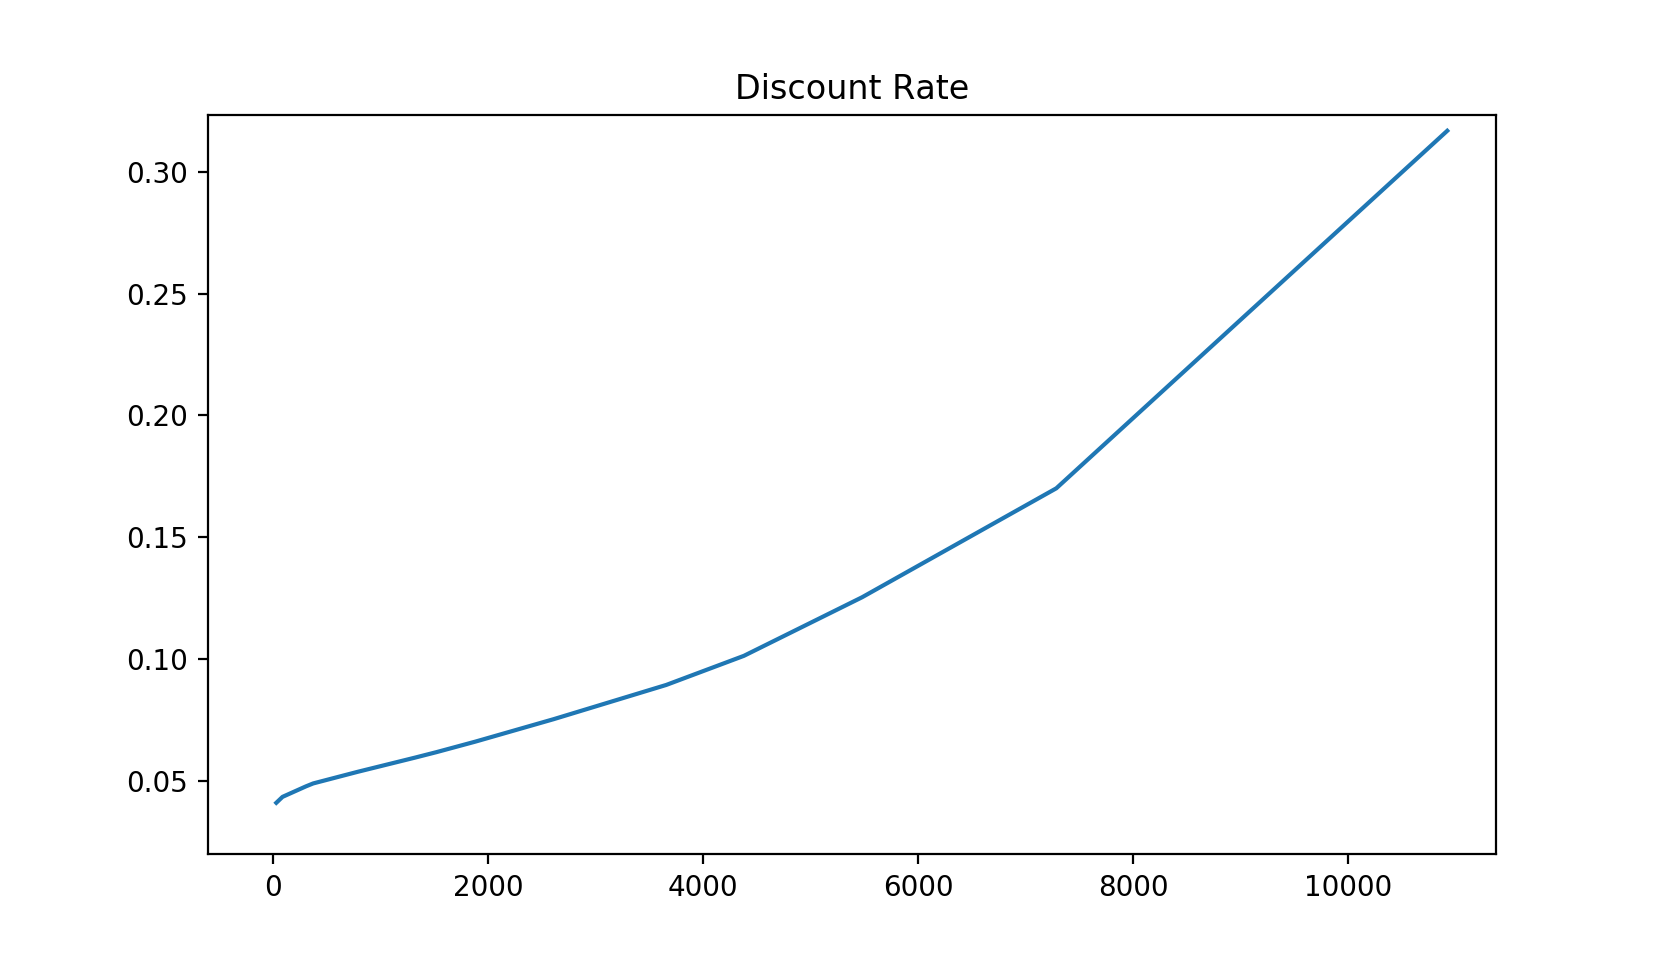

In [889]:
x = np.arange(28, 10920)
plt.plot(x, tiie28.rate_curve(x))
plt.title("Discount Rate");

<IPython.core.display.Javascript object>


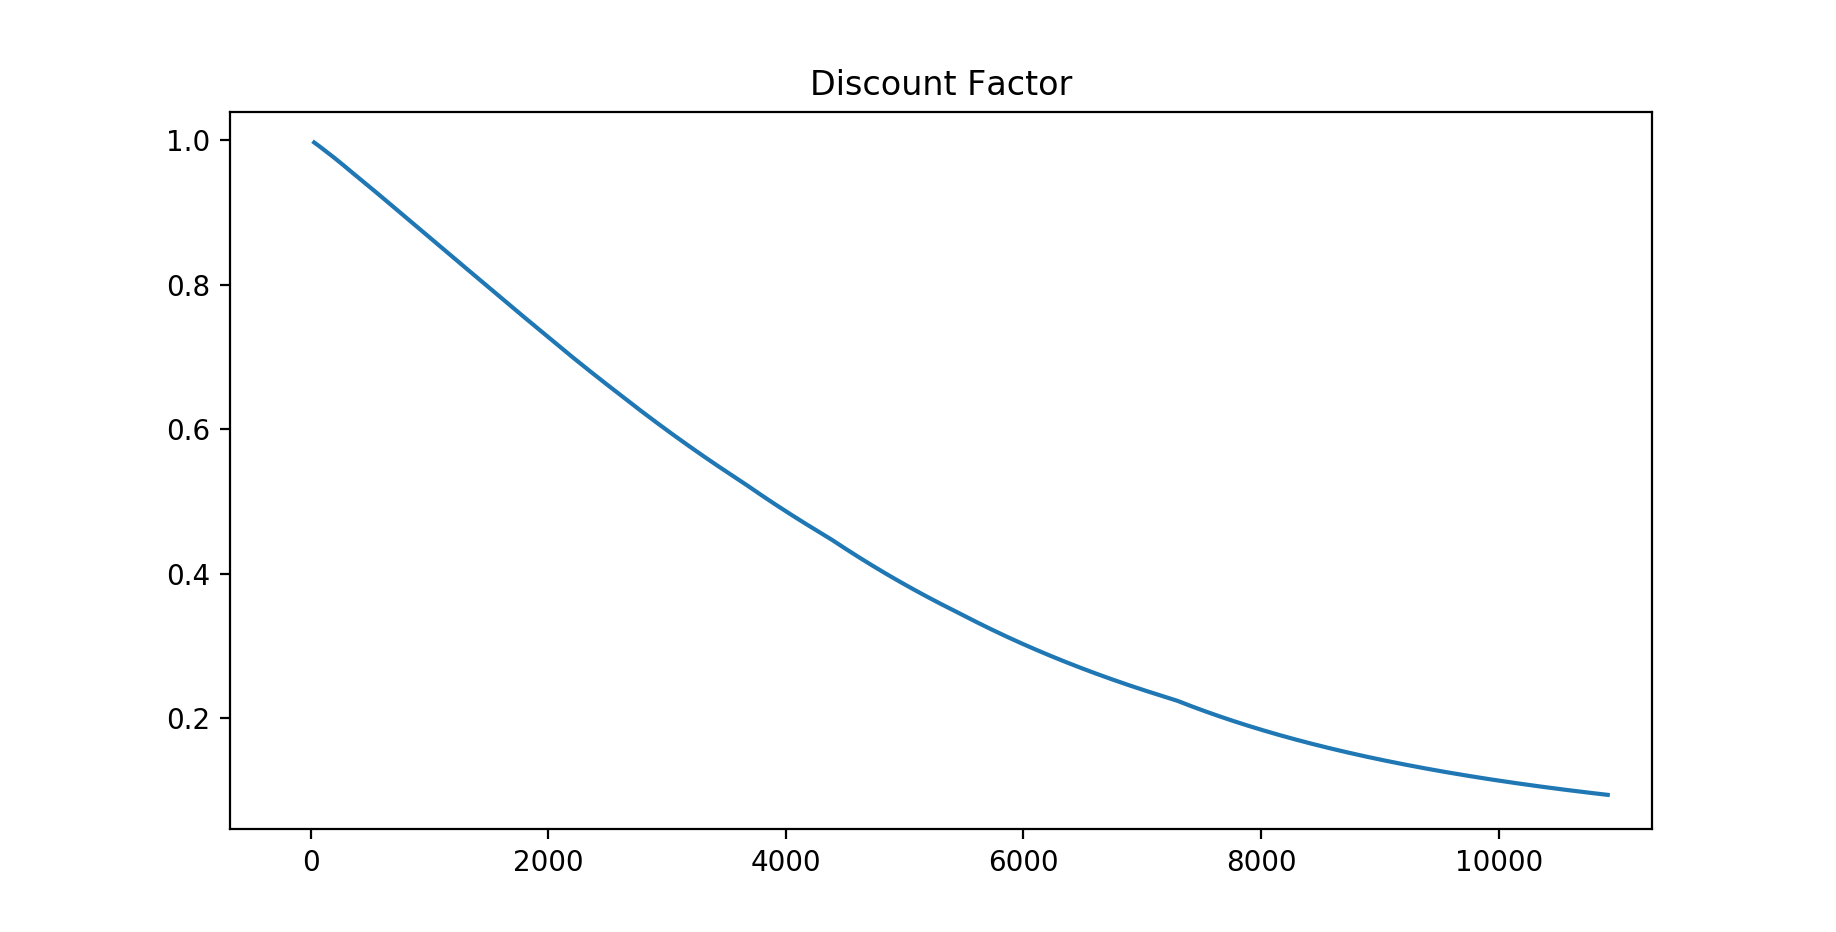

In [890]:
x = np.arange(28, 10920)
plt.plot(x, 1 /( 1 + tiie28.rate_curve(x) * x / 360))
plt.title("Discount Factor");